In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
mypath = 'Datos_Provs' #path with files to analyze
from matplotlib.ticker import AutoMinorLocator
files = [f for f in listdir(mypath) if isfile(join(mypath, f))] #get all file names of that path
from scipy.optimize import curve_fit
plt.style.use('seaborn')
plt.style.use('matplotlibrc.py')

In [2]:
def get_Error(file_name):
    #error analysis, where file_name is the name of the file to analyze
    #i dont include mypath as an arg bc it's a global variable
    file_dir = mypath + '/' + str(file_name)
    data = pd.read_csv(file_dir,sep=",",quotechar='"',parse_dates=["fecha"],na_values=[''])
    df = pd.DataFrame(data)
    df.sort_values(by=["fecha"])
    #dates formatting
    first_day = min(df["fecha"])
    last_day = max(df["fecha"])
    df["fecha"] -= first_day
    df.fecha = df.fecha.dt.days
    df = df.groupby(["fecha"], as_index=False).mean()
    df = df.to_numpy() #to numpy array (date,rho7d,inc14days,riskper10)
    #data analysis per se
    last = df.shape[0]
    df = np.hstack((df,np.zeros((last,1))))
    i = 19
    while i < last:
        df[i,4] = df[i-7,3]
        i = i+1
    error = abs(df[19:,4]-df[19:,2])
    return error,df[19:,1]

In [3]:
#apparently theres like no function to make this thing i want
def make_hist(file_name,error,r_seven,bs,loc=2,save=False):
    error = error[:-10]
    r_seven = r_seven[:-10]
    error = abs(error)
    max_v = round(max(r_seven),1) 
    min_v = round(min(r_seven),1)
    r_bins = np.arange(min_v,max_v+bs,bs) #bin range
    rr_bins = np.arange(min_v,max_v+bs,bs*loc) #the loc factor comes into pay here
    n_size = r_bins.shape[0]-1 #amount of bins
    c_bins = np.zeros(n_size) #center of bins
    e_bins = np.zeros(n_size) #errors with same size
    std_bins = np.zeros(n_size) #std of bins 
    o_bins = np.zeros(n_size) #amount of observations for that bin
    i = 0 #this is just a counter
    #now we count for each bin based on error
    cuenta = 0
    while i < n_size:
        indices1 = ((i*bs)+min_v<=r_seven)
        indices2 = (r_seven < min_v + (i+1)*bs)
        indices = indices1*indices2
        errores = np.copy(error[indices])
        cuenta = errores.shape[0]
        if errores.size == 0:
            m_errores = 0
            m_std = 0
        else:
            m_errores = np.mean(errores)
            m_std = np.std(errores)/np.sqrt(cuenta)
        e_bins[i] = m_errores
        std_bins[i] = m_std
        o_bins[i] = cuenta
        c_bins[i] = (2*i+1)*(bs/2) + min_v
        i = i +1
    plt.figure()
    #plt.title(str(file_name)+' - Error-R7')
    ax = plt.axes()
    ax.set_xticks(rr_bins)
    ax.set_xticklabels(())
    ax.set_xticklabels((rr_bins.round(2)))
    plt.xlabel(r'$R_{t}^{7}$')
    plt.ylabel('Error absoluto promedio')
    ax.xaxis.set_minor_locator(AutoMinorLocator(2)) #for minor ticks to be visible its the easiest i could find tbh
    plt.xticks(fontsize=12)
    #plt.grid()
    plt.bar(c_bins, e_bins, bs, color='r',edgecolor='k',yerr=std_bins)
    plt.savefig(str(file_name)+'_Hist.pdf',bbox_inches='tight')
    plt.show()
    return c_bins,e_bins,std_bins,o_bins

In [4]:
def chunks(lst,a,n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n],a[i:i + n]

In [46]:
#new hist with a much better approach and easier and faster
def new_hist(file_name,error,r_seven,bs,loc=2,save=False):
    error = error[:-10]
    r_seven = r_seven[:-10]
    #indices = (r_seven <= 2)
    #r_seven = r_seven[indices]
    #error = error[indices]
    error = abs(error)
    r_sevens, errores= (list(t) for t in zip(*sorted(zip(r_seven, error)))) #ordeno por orden del r_seven
    hist_graf = [] #minimos y maximos consecutivos
    c_bins = []
    e_bins = []
    std_bins = []
    obs_bins = []
    x = chunks(r_sevens,errores,bs)
    for i in x:
        rs = i[0]
        es = i[1]
        hist_graf.append(min(rs))
        hist_graf.append(max(rs))
        c_bins.append(np.mean(rs))
        e_bins.append(np.mean(es))
        obs_bins.append(len(es))
        std_bins.append(np.std(es)/np.sqrt(len(es)))
    plt.errorbar(c_bins,e_bins,yerr=std_bins,fmt='-ok',visible=False)
    y_min, y_max = plt.gca().get_ylim()
    axes = plt.gca()
    axes.set_ylim([0.0,y_max])
    grouped_lists = [hist_graf[n:n+2] for n in range(0, len(hist_graf), 2)]
    i = 0
    a = 0
    for g in grouped_lists:
        if(g[0] > a):
            plt.axvspan(a,g[1],ymax=float(e_bins[i]/(y_max)),facecolor='r',edgecolor='k',alpha=1.0)
        else:
            plt.axvspan(g[0],g[1],ymax=float(e_bins[i]/(y_max)),facecolor='r',edgecolor='k',alpha=1.0)
        i = i + 1
        a = np.copy(g[1])
    plt.xlabel(r'$R_{t}^{7}$')
    plt.ylabel('Error absoluto promedio')
    plt.savefig(str(file_name)+'_Hist_Nuevo.pdf',bbox_inches='tight')
    plt.show()
    return c_bins,e_bins,std_bins,obs_bins

In [6]:
#grafico log-log
def graph_loglog(b_centers,b_errors,b_std,file_name):
    #save_data(b_centers,b_errors,c_obs,'BuenosAires_hist_2')
    b_centers = b_centers[b_errors!=0]
    b_std = b_std[b_errors!=0]
    b_errors = b_errors[b_errors!=0]
    max_errors = np.argmax(b_errors)
    max_rseven = b_centers[max_errors]
    #separo a un lado
    b_centers_1 = b_centers[:max_errors]
    b_errors_1 = b_errors[:max_errors]
    b_std_1 = b_std[:max_errors]
    #separo al otro lado
    b_centers_2 = b_centers[max_errors:]
    b_errors_2 = b_errors[max_errors:]
    b_std_2 = b_std[max_errors:]
    #imprimo a ver si esta bien
    #print(b_centers_1,b_centers_2)
    #grafico
    plt.errorbar(np.log(np.abs(b_centers_1-1)),np.log(b_errors_1),yerr=b_std_1,label='Menor al máximo',fmt='-o')
    plt.errorbar(np.log(np.abs(b_centers_2-1)),np.log(b_errors_2),yerr=b_std_2,label='Mayor al máximo',fmt='-s')
    plt.xlabel('$log|R_{t}^{7} - 1|, {R_{t}^{7}}_{max} = $'+str(round(max_rseven,2)))
    plt.ylabel(r'log|Error absoluto promedio|')
    plt.legend(fontsize=12)
    #plt.grid()
    plt.savefig(str(file_name)+'_LogLog_Nuevo.pdf',bbox_inches='tight')
    plt.show()

In [7]:
def save_data(b_centers,b_errors,b_std,c_obs,string):
    matriz = np.zeros((len(c_obs),4))
    matriz[:,0] = b_centers
    matriz[:,1] = b_errors
    matriz[:,2] = b_std
    matriz[:,3] = c_obs
    np.savetxt(string+'.txt',matriz,delimiter=',',header='Bin Centers,Abs Mean Error,Mean SE,Observations')

# grafico aca el tema de los errores - func de R7 (log-log)

In [ ]:
def exponential(x,a,b):
    return a*(x**b)

# todos los graficos nuevos

# los histogramas comunes

In [ ]:
for file in files:
    bs = 0.2
    file_name = file
    error,r_seven = get_Error(file_name)
    b_centers,b_errors,b_std,c_obs = make_hist(file_name,error,r_seven,bs,loc=2) 
    #plt.plot(b_centers,b_errors**(1/0.5),'-ob')
    #save_data(b_centers,b_errors,b_std,c_obs,file_name)
    graph_loglog(b_centers,b_errors,b_std,file_name)

In [ ]:
break

# los histogramas nuevos

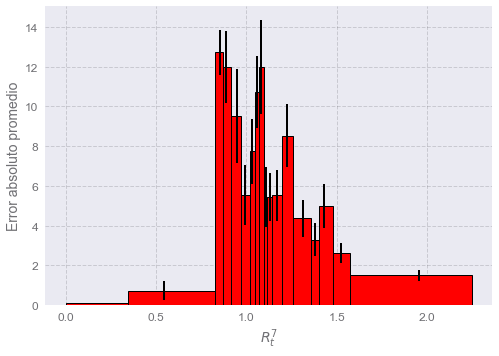

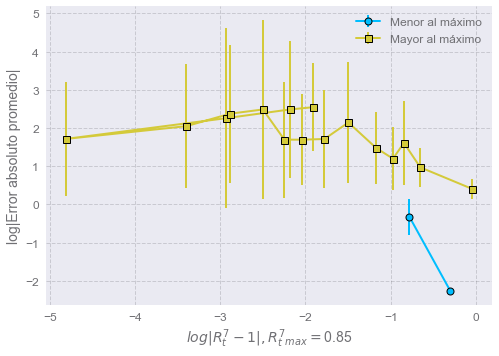

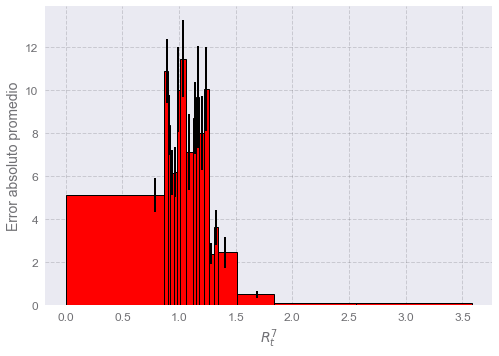

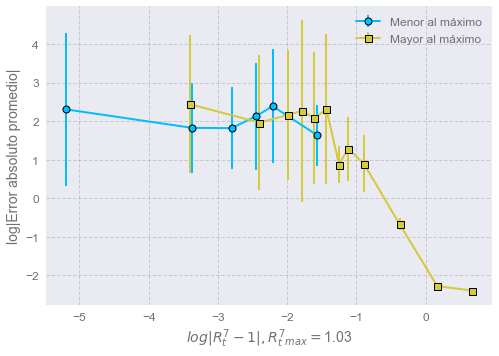

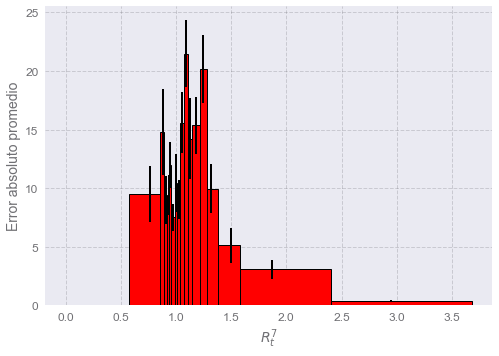

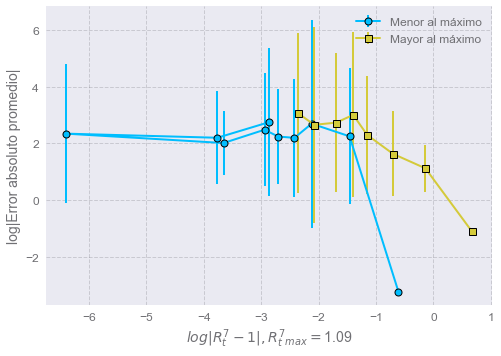

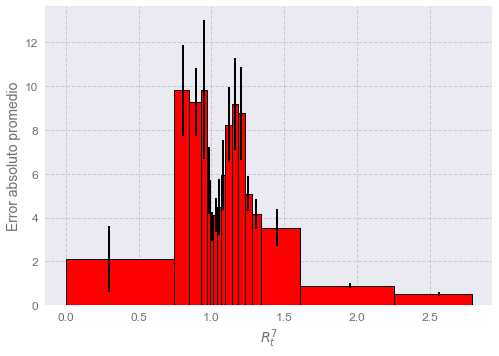

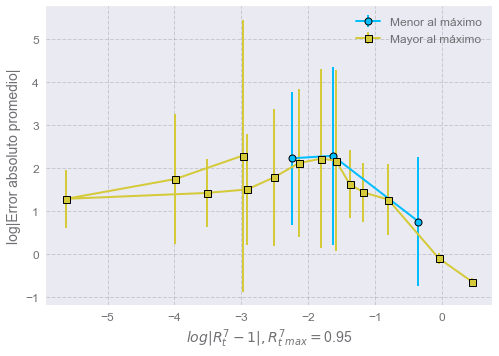

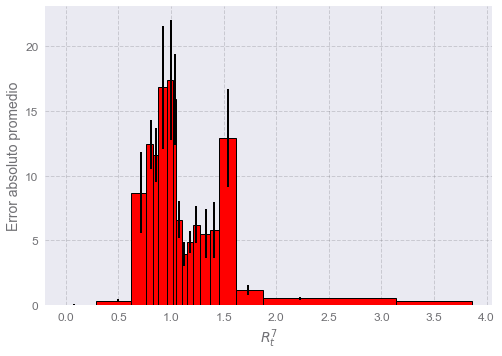

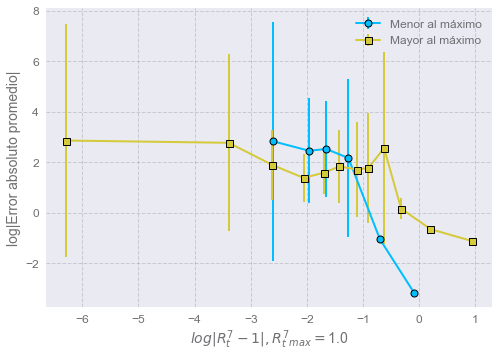

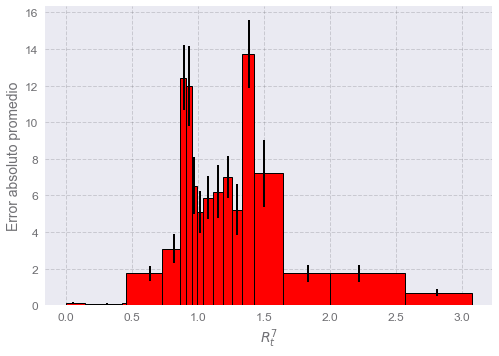

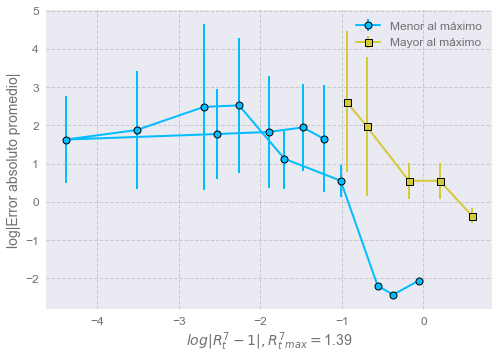

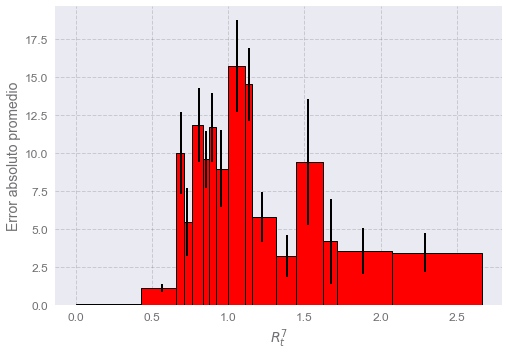

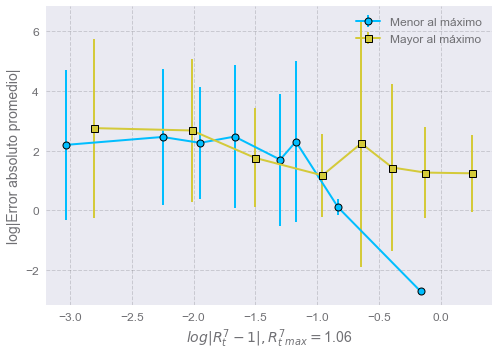

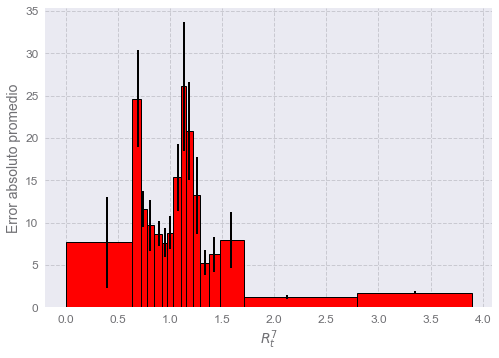

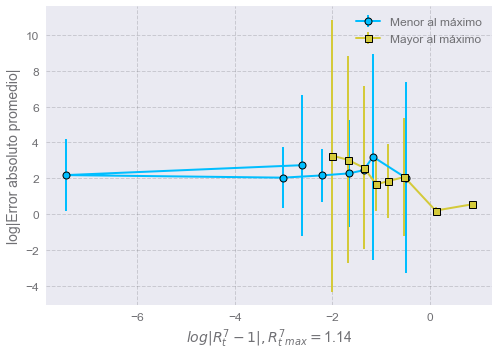

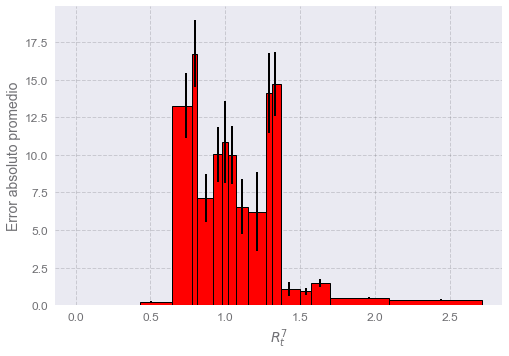

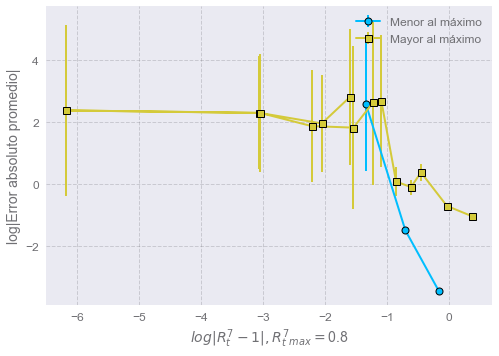

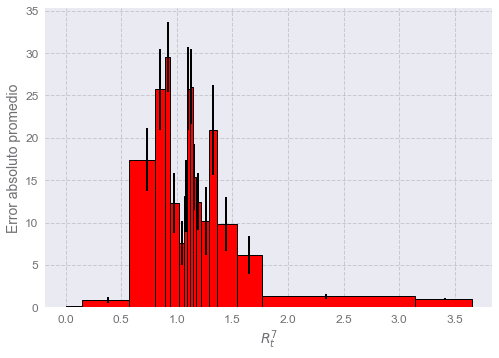

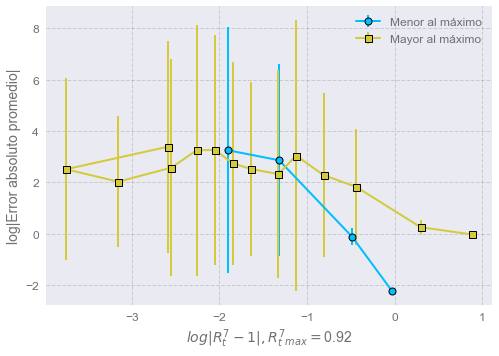

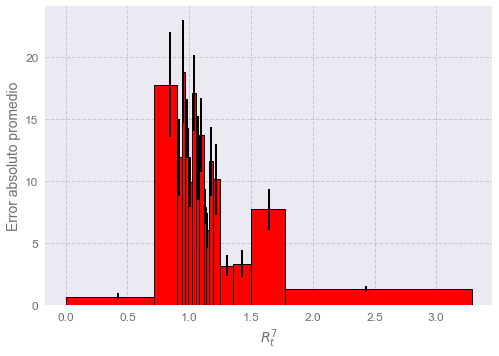

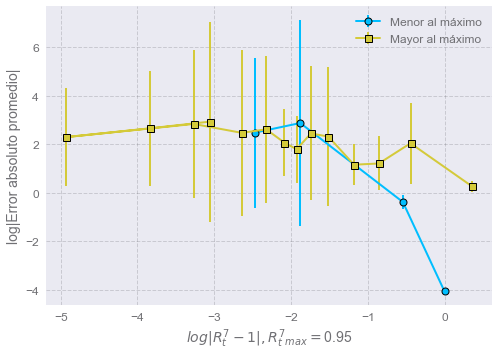

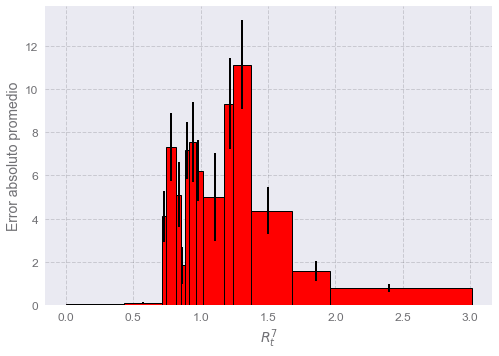

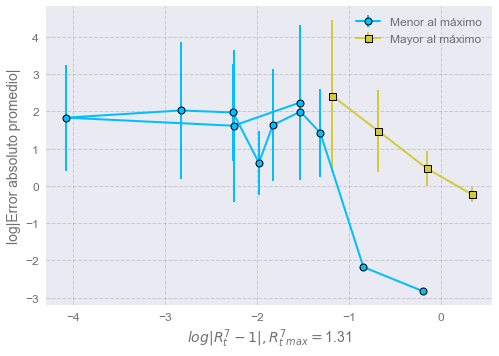

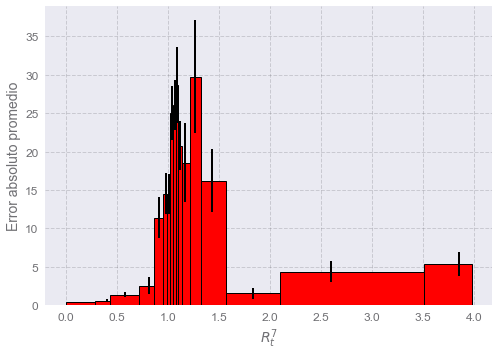

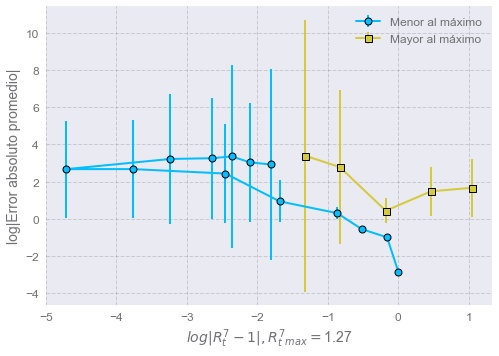

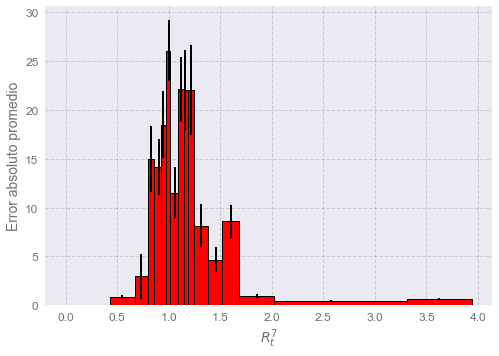

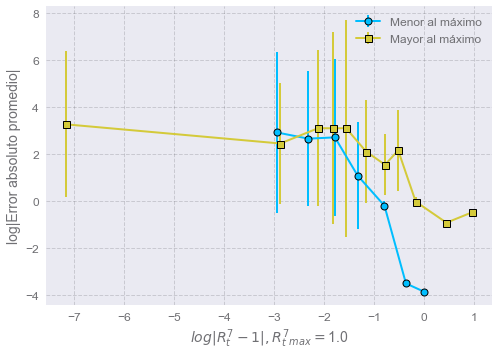

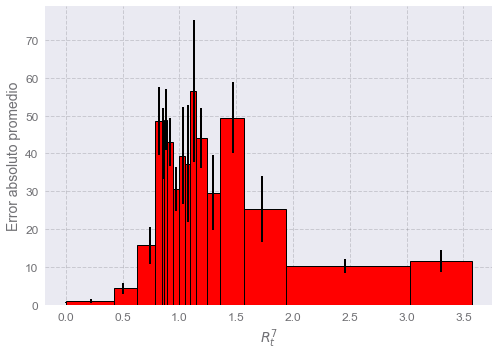

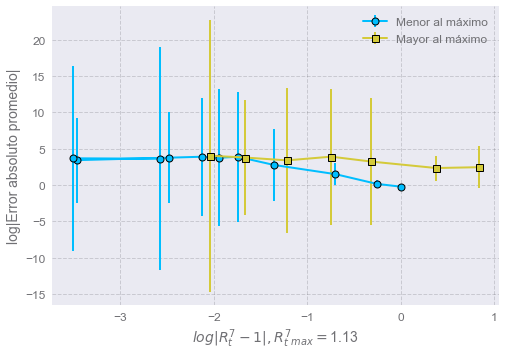

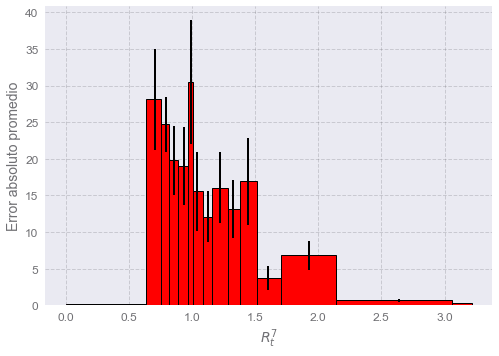

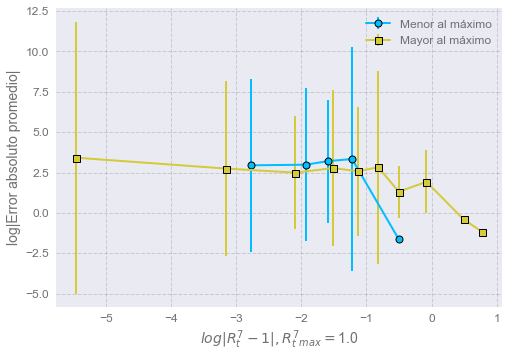

In [47]:
for file in files:
    bs = 20
    file_name = file
    error,r_seven = get_Error(file_name)
    c_bins,e_bins,std_bins,obs_bins = new_hist(file_name,error,r_seven,bs,loc=2)
    graph_loglog(np.array(c_bins),np.array(e_bins),np.array(std_bins),file_name)
    #plt.plot(np.array(c_bins),np.array(e_bins)**(1/0.8),'-ob')